# Meridional Heat Transport (MHT)
This notebook calculates the model MHT from three ways, based on distinct MOM5 diagnostics:

1. `temp_yflux_adv_int_z` (depth-integrated meridional heat transport due to resolved advection),

2. `net_sfc_heating` (net surface heat flux), and

3. `ty_trans`, `temp`, `dx` and `dzt` (depth- and zonally-integrated product of meridional transport and temperature).

To use this notebook, we need to ensure this diagnostic is available in the model output. We can check if a variable is available using `cc.querying.get_variables()` function from the COSIMA cookbook.  

The third method is memory-intensive, so we recommend using at least 128 GB of memory. Alternatively, select a smaller temporal or spatial region of interest.
  
Note that currently this notebook calculates the total (all basins) MHT and it also includes comparisons to a few observational products. Basin-specific MHT can be calculated by defining relevant masks (see for e.g., https://github.com/COSIMA/cosima-recipes/blob/main/DocumentedExamples/Atlantic_IndoPacific_Basin_Overturning_Circulation.ipynb).

## Loading relevant libraries

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Loading model data

We will use the COSIMA cookbook to search its database and load `temp_yflux_adv_int_z` to start our calculations. To do this we will need to do the following:
1. Start a COSIMA cookbook session
2. Define the model configuration of interest
3. Define the experiment of interest
4. Define the diagnostic (variable) of interest

**NOTE:** If you are in doubt about the models, experiments and diagnostics available in the database, check the [Cookbook Tutorial](../Tutorials/COSIMA_CookBook_Tutorial.ipynb) for more information.

In [2]:
#Start a COSIMA cookbook session
session = cc.database.create_session()

#Define experiment of interest
experiment = '025deg_jra55v13_iaf_gmredi6'

We are now ready to query the database and load the data to start our analysis. We load `temp_yflux_adv_int_z`. For this example, we have chosen to use 6 years of output.

## Method 1: using depth-integrated meridional heat transport due to resovled advection

In [3]:
mht_method1 = cc.querying.getvar(experiment, 'temp_yflux_adv_int_z', session, n=3)
mht_method1

<xarray.DataArray 'temp_yflux_adv_int_z' (time: 72, yu_ocean: 1080,
                                          xt_ocean: 1440)>
dask.array<concatenate, shape=(72, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * time      (time) datetime64[ns] 2198-01-14T12:00:00 ... 2203-12-14T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
Attributes:
    long_name:      z-integral of cp*rho*dxt*v*temp
    units:          Watts
    valid_range:    [-1.e+18  1.e+18]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_c
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Viewing the variable containing our data provides a number of key information, including:
- *Shape of dataset* - In this case the data includes 72 time steps, 1080 steps along the y axis and 1440 along the x axis.
- *Name of coordinates* - Our data includes `time`, `yu_ocean` (i.e., latitude), and `xt_ocean` (i.e., longitude).
- *Values included under each coordinate* - We can see that `time` includes monthly values from 2198-01-14 to 2203-12-14.
- *Metadata* - This information is included under `Attributes` and it includes things like units.

## Calculating mean and converting units
From the metadata, we can see that our dataset is in Watts (W), so we will convert them to petawatts (PW)

In [4]:
mht_method1 = mht_method1 * 1e-15
mht_method1 = mht_method1.assign_attrs(units='PettaWatts')
mht_method1

<xarray.DataArray 'temp_yflux_adv_int_z' (time: 72, yu_ocean: 1080,
                                          xt_ocean: 1440)>
dask.array<mul, shape=(72, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * time      (time) datetime64[ns] 2198-01-14T12:00:00 ... 2203-12-14T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
Attributes:
    units:    PettaWatts

and then we compute the mean across `time` and sum over all longitudes.

In [5]:
mht_method1 = mht_method1.mean('time').sum('xt_ocean')
mht_method1

<xarray.DataArray 'temp_yflux_adv_int_z' (yu_ocean: 1080)>
dask.array<sum-aggregate, shape=(1080,), dtype=float32, chunksize=(540,), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0

## Method 2: using from the net surface heat flux (assuming steady state)

First, we load the surface heat flux and grid metrics:

In [6]:
shflux = cc.querying.getvar(experiment, 'net_sfc_heating', session, n=3)
shflux_am = shflux.mean('time').load()

area = cc.querying.getvar(experiment, 'area_t', session, ncfile="ocean_grid.nc", n=1)
lat  = cc.querying.getvar(experiment, 'geolat_t', session, ncfile="ocean_grid.nc", n=1)
latv = cc.querying.getvar(experiment, 'yt_ocean', session, ncfile="ocean_grid.nc", n=1)

Now calculate Meridional Heat Flux (MHF):

$\textrm{MHF} = \textrm{Cumulative sum of } (\textrm{SHFLUX} \times \textrm{AREA}) \textrm{ along latitudes}$

**Note**: The following cell might take 1-2 min.

In [7]:
%%time

mhf = xr.zeros_like(latv)

for i in range(len(latv)):
    inds = lat < latv[i]
    atmp = area.where(lat < latv[i])
    stmp = shflux_am.where(lat < latv[i])
    mhf[i] = np.sum(atmp * stmp)

mht_method2 = mhf + (mhf[0] - mhf[-1]) / 2

CPU times: user 1min 18s, sys: 2.12 s, total: 1min 20s
Wall time: 51.1 s


In [8]:
#We transform units from watts to petawatts
mht_method2 = mht_method2 * 1e-15
mht_method2 = mht_method2.assign_attrs(units='PettaWatts')
mht_method2

<xarray.DataArray 'yt_ocean' (yt_ocean: 1080)>
array([ 0.11841208,  0.11841208,  0.11841208, ..., -0.11841084,
       -0.11841175, -0.11841208])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    units:    PettaWatts

## Method 3: Using 3D transport and potential temperature 

This method computes the MHF using meridional transport (or alternatively, meridional velocities mapped on to the transport grid) and potential temperature diagnostics. For this method to work, the net transport across each latitude section must be zero. Then, the MHF can be understood as the product of northward (or southward) flow with the temperature difference between the northward and southward flow. 

We choose an experiment which contains monthly data fields to capture monthly temporal correlations between meridional transport and temperature:

In [9]:
experiment = '025deg_jra55_ryf9091_gadi'

Cp = 3992.10  # Reference heat capacity in J / (kg C)

We interpolate each variable on to x-center and y-face grid as we are estimating a tracer across a given latitude:

In [10]:
V = cc.querying.getvar(experiment, 'ty_trans', session, frequency = '1 monthly', n = 3)
θ = cc.querying.getvar(experiment, 'temp', session, frequency = '1 monthly', n = 3)
dxt = cc.querying.getvar(experiment, 'dxt', session, frequency = 'static', n = 1)
dzt = cc.querying.getvar(experiment, 'dzt', session, frequency = '1 monthly', n = 3)

θ = θ.interp(yt_ocean = V.yu_ocean.values, method = "linear").rename({'yt_ocean': 'yu_ocean'})
dzt = dzt.interp(yt_ocean = V.yu_ocean.values, method = "linear").rename({'yt_ocean': 'yu_ocean'})
dxt = dxt.interp(yt_ocean = V.yu_ocean.values, method = "linear").rename({'yt_ocean': 'yu_ocean'})

V = V.sel(yu_ocean = slice(-75, 85))
θ = θ.sel(yu_ocean = slice(-75, 85))
dxt = dxt.sel(yu_ocean = slice(-75, 85))
dzt = dzt.sel(yu_ocean = slice(-75, 85))

We ensure zero net transport across a given latitude by subtracting mean flow ($v_m(y,t)$) across that latitude:
\begin{equation}
    v_m(y,t) = \frac{\iint v(x,y,z,t) \, dx dz}{\iint \, dx dz},
\end{equation}
where $v(x,y,z,t)$ is the meridional velocity at a given latitude. From this, the no-mean velocity ($v_{nm} (x,y,z,t)$) is given by:
\begin{equation}
    v_{nm} (x,y,z,t) = v(x,y,z,t) - v_m(y,t).
\end{equation}

The no-mean velocity is then used to evaluate the MHF using:
\begin{equation}
    MHF(y,t) = \iint \rho C_p v_{nm} (x,y,z,t) \theta(x,y,z,t) \, dx dz,
\end{equation}
where we time-average the MHF in the end.

**Note**: The following cell takes about 2.5 minutes per model year. Above, we have selected 6 years of data.

In [11]:
%%time

v = V / (dxt * dzt)
v_mean = (V.sum('xt_ocean').sum('st_ocean')) / ((dzt * dxt).sum('xt_ocean').sum('st_ocean'))
v_nm = v - v_mean

HT = (Cp * v_nm * θ * dzt * dxt).sum('xt_ocean').sum('st_ocean').mean('time')

mht_method3 = (HT * 1e-15) # Watts to Pettawatts
mht_method3 = mht_method3.assign_attrs(units='PettaWatts').load()
mht_method3

CPU times: user 13min 28s, sys: 1min 25s, total: 14min 54s
Wall time: 7min 25s


<xarray.DataArray (yu_ocean: 974)>
array([-0.00849248, -0.00929472, -0.01011939, -0.01073074, -0.01101982,
       -0.01120518, -0.01151922, -0.01228014, -0.01318378, -0.01401125,
       -0.0148169 , -0.01572145, -0.01664795, -0.01773844, -0.01887096,
       -0.01997408, -0.02054121, -0.02108926, -0.02237917, -0.02317413,
       -0.02361475, -0.02471396, -0.02597232, -0.02731665, -0.02817157,
       -0.02907604, -0.02970454, -0.02994487, -0.03131153, -0.03329881,
       -0.03476248, -0.03533748, -0.03605816, -0.03681903, -0.03715564,
       -0.03767137, -0.03899816, -0.04073014, -0.04198729, -0.04252496,
       -0.04367679, -0.04485429, -0.04638374, -0.04802542, -0.04958772,
       -0.05125772, -0.05225766, -0.05283952, -0.05384258, -0.05414464,
       -0.05362169, -0.05481236, -0.05718146, -0.05925867, -0.06101393,
       -0.06306791, -0.06544326, -0.06761371, -0.06986877, -0.07240626,
       -0.0749488 , -0.07697841, -0.07881691, -0.08028585, -0.08195637,
       -0.08341195, -0.08497993, -0.08704694, -0.08897822, -0.09088285,
       -0.09218846, -0.09362864, -0.09513164, -0.09712111, -0.09877308,
       -0.09962089, -0.09978513, -0.10013551, -0.10086104, -0.10314351,
       -0.10547657, -0.10780042, -0.10951895, -0.11113191, -0.11245935,
       -0.11297018, -0.11370449, -0.11541926, -0.11722916, -0.1186038 ,
       -0.11968008, -0.1208274 , -0.12162922, -0.12307851, -0.12441016,
       -0.12630118, -0.12947132, -0.13263413, -0.13553622, -0.13889143,
...
        0.09117905,  0.08984599,  0.08863715,  0.08751361,  0.08634488,
        0.08502971,  0.08376497,  0.08247944,  0.08104267,  0.07967313,
        0.07799207,  0.07599685,  0.07409217,  0.07227354,  0.07058508,
        0.06886184,  0.06739407,  0.06613889,  0.06505343,  0.06351282,
        0.06151949,  0.05961027,  0.05802029,  0.05669088,  0.05554212,
        0.05415215,  0.05265313,  0.05109212,  0.04952814,  0.04804014,
        0.04660476,  0.04521364,  0.04376896,  0.042246  ,  0.04081539,
        0.03921349,  0.0372604 ,  0.03521107,  0.03300504,  0.03127239,
        0.02990471,  0.02831413,  0.02680944,  0.02559691,  0.02465738,
        0.02379707,  0.02294725,  0.02203393,  0.02103949,  0.02016667,
        0.01930691,  0.01860906,  0.01797675,  0.0172467 ,  0.01644143,
        0.0155392 ,  0.01485677,  0.01439781,  0.0139737 ,  0.01348683,
        0.01301665,  0.01258003,  0.01235652,  0.01198022,  0.01151646,
        0.01100976,  0.01044618,  0.01010816,  0.00977771,  0.00929953,
        0.00888783,  0.00849151,  0.00812897,  0.00783823,  0.00776431,
        0.00757076,  0.00738114,  0.00723703,  0.00688715,  0.00671832,
        0.00665374,  0.00658163,  0.00653205,  0.00629973,  0.00630955,
        0.00626328,  0.00589651,  0.00558278,  0.00558823,  0.00553226,
        0.00518413,  0.00526254,  0.00515577,  0.00501462,  0.00478384,
        0.00462871,  0.00450485,  0.00430556,  0.00409292], dtype=float32)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -74.9 -74.79 -74.69 ... 84.72 84.83 84.93
Attributes:
    units:    PettaWatts

## Comparison between model output and observations
Before producing our figure, we will compare the model output with observations to check the model accuracy.

### Read ERBE Period Ocean and Atmospheric Heat Transport
Observations are also available in Gadi, here we show how to load them to our notebook.

In [12]:
#Path to the file containing observations
filename = '/g/data3/hh5/tmp/cosima/observations/original/MHT/obs_vq_am_estimates.txt'

#Creating empty variables to store our observations
erbe_mht = []
erbe_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
    #Open each line from rows 1 to 96
    for line in f.readlines()[1:96]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting latitude and MHT and saving to empty variables
        erbe_lat.append(float(sline[0]))
        erbe_mht.append(float(sline[3]))

#Checking MHT variables
erbe_mht

[7.82256e-05,
 -0.00548183,
 -0.00534277,
 -0.00778958,
 -0.0153764,
 -0.0189109,
 -0.0172473,
 -0.0321044,
 -0.0647783,
 -0.104008,
 -0.129806,
 -0.202605,
 -0.297446,
 -0.374377,
 -0.424618,
 -0.464923,
 -0.508466,
 -0.544651,
 -0.56517,
 -0.575634,
 -0.563567,
 -0.51931,
 -0.45106,
 -0.377069,
 -0.310393,
 -0.271679,
 -0.279999,
 -0.329881,
 -0.39744,
 -0.464742,
 -0.515384,
 -0.565431,
 -0.620221,
 -0.678495,
 -0.736833,
 -0.790937,
 -0.843637,
 -0.90752,
 -0.984516,
 -1.05272,
 -1.0956,
 -1.10212,
 -1.05218,
 -0.93882,
 -0.761357,
 -0.502307,
 -0.155427,
 0.253559,
 0.666604,
 1.00846,
 1.25254,
 1.42962,
 1.57235,
 1.69269,
 1.78862,
 1.84355,
 1.85095,
 1.82898,
 1.79722,
 1.76105,
 1.71365,
 1.65596,
 1.59826,
 1.53441,
 1.45553,
 1.34517,
 1.20096,
 1.03473,
 0.856831,
 0.704894,
 0.62273,
 0.602973,
 0.60382,
 0.602437,
 0.599438,
 0.588678,
 0.573292,
 0.5557,
 0.518399,
 0.46073,
 0.40554,
 0.361088,
 0.328643,
 0.303888,
 0.271855,
 0.232879,
 0.18562,
 0.146825,
 0.110927

### Read NCEP and ECMWF Oceanic and Atmospheric Transport Products

In [13]:
#Path to the file containing observations
filename = '/g/data3/hh5/tmp/cosima/observations/original/MHT/ANNUAL_TRANSPORTS_1985_1989.ascii'

#Creating empty variables to store our observations
ncep_g_mht = []
ecwmf_g_mht = []
ncep_g_err = []
ecwmf_g_err = []
ncep_a_mht = []
ecwmf_a_mht = []
ncep_a_err = []
ecwmf_a_err = []
ncep_p_mht = []
ecwmf_p_mht = []
ncep_p_err = []
ecwmf_p_err = []
ncep_i_mht = []
ecwmf_i_mht = []
ncep_i_err = []
ecwmf_i_err = []
ncep_ip_mht = []
ecwmf_ip_mht = []
ncep_ip_err = []
ecwmf_ip_err = []
o_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
#Open each line in file (ignoring the first row)
    for line in f.readlines()[1:]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting values and saving to correct variable defined above
        o_lat.append(float(sline[0])*0.01)  # T42 latitudes (north to south)
        ncep_g_mht.append(float(sline[4])*0.01) # Residual Ocean Transport - NCEP
        ecwmf_g_mht.append(float(sline[5])*0.01)# Residual Ocean Transport - ECWMF
        ncep_a_mht.append(float(sline[7])*0.01)# Atlantic Ocean Basin Transport - NCEP
        ncep_p_mht.append(float(sline[8])*0.01)# Pacific Ocean Basin Transport - NCEP
        ncep_i_mht.append(float(sline[9])*0.01)# Indian Ocean Basin Transport - NCEP
        ncep_g_err.append(float(sline[10])*0.01)# Error Bars for NCEP Total Transports
        ncep_a_err.append(float(sline[11])*0.01)# Error Bars for NCEP Atlantic Transports 
        ncep_p_err.append(float(sline[12])*0.01)# Error Bars for NCEP Pacific Transports 
        ncep_i_err.append(float(sline[13])*0.01)# Error Bars for NCEP Indian Transports 
        ecwmf_a_mht.append(float(sline[15])*0.01)# Atlantic Ocean Basin Transport - ECWMF
        ecwmf_p_mht.append(float(sline[16])*0.01)# Pacific Ocean Basin Transport - ECWMF
        ecwmf_i_mht.append(float(sline[17])*0.01)# Indian Ocean Basin Transport - ECWMF
        ecwmf_g_err.append(float(sline[18])*0.01)# Error Bars for ECWMF Total Transports
        ecwmf_a_err.append(float(sline[19])*0.01)# Error Bars for NCEP Atlantic Transports
        ecwmf_p_err.append(float(sline[20])*0.01)# Error Bars for NCEP Pacific Transports
        ecwmf_i_err.append(float(sline[21])*0.01)# Error Bars for NCEP Indian Transports

#Calculating MHT
ncep_ip_mht  = [a+b for a, b in zip(ncep_p_mht,ncep_i_mht)]
ecwmf_ip_mht = [a+b for a, b in zip(ecwmf_p_mht,ecwmf_i_mht)]
ncep_ip_err  = [max(a, b) for a, b in zip(ncep_p_err, ncep_i_err)]
ecwmf_ip_err = [max(a, b) for a, b in zip(ecwmf_p_err, ecwmf_i_err)]

## Plotting model outputs against observations

We plot the global meridional heat transport as calculated from model outputs (blue line) and observations.

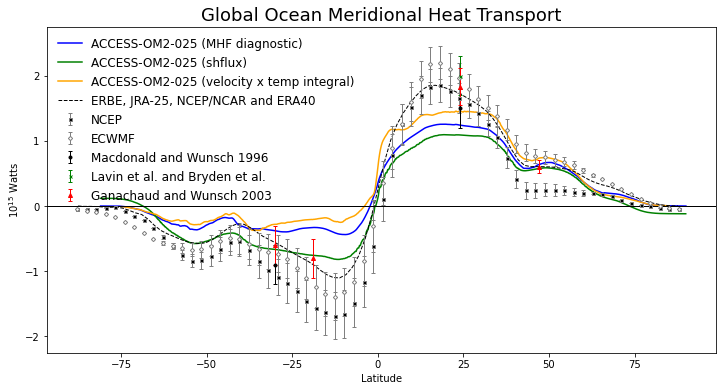

In [14]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

#Plotting MHT from model outputs
mht_method1.plot(ax = ax, color="blue", label="ACCESS-OM2-025 (MHF diagnostic)")
mht_method2.plot(ax = ax, color="green", label="ACCESS-OM2-025 (shflux)")
mht_method3.plot(ax = ax, color = 'orange', label = 'ACCESS-OM2-025 (velocity x temp integral)')

#Adding observations and error bars for observations
ax.plot(erbe_lat, erbe_mht, 'k--', linewidth=1, label="ERBE, JRA-25, NCEP/NCAR and ERA40")
plt.errorbar(o_lat[::-1], ncep_g_mht[::-1], yerr=ncep_g_err[::-1], c='gray', fmt='s', 
             markerfacecolor='k', markersize=3, capsize=2, linewidth=1, label="NCEP")
plt.errorbar(o_lat[::-1], ecwmf_g_mht[::-1], yerr=ecwmf_g_err[::-1], c='gray', fmt='D', 
             markerfacecolor='white', markersize=3, capsize=2, linewidth=1, label="ECWMF")
plt.errorbar(24, 1.5, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1, 
             label="Macdonald and Wunsch 1996")
plt.errorbar(-30, -0.9, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1)
plt.errorbar(24, 2.0, yerr=0.3, fmt='x', c='green', markersize=3, capsize=2, linewidth=1, 
             label="Lavin et al. and Bryden et al.")
plt.errorbar(24, 1.83, yerr=0.28, fmt='^', c='red', markersize=4, capsize=2, linewidth=1, 
             label="Ganachaud and Wunsch 2003")
plt.errorbar(-30, -0.6, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(-19, -0.8, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(47, 0.6, yerr=0.1, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)

#Adding legend
plt.legend(frameon=False, fontsize=12)
plt.axhline(y=0, linewidth=1, color='black')

#Defining plot limits along the y axis
plt.ylim(-2.25, 2.75)

#Adding titles for figure and axes
plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude')
plt.ylabel('$10^{15}$ Watts');

Differences between the 1st and 3rd methods are expected because:
1. the 3rd method is unable to capture sub-monthly cross-correlations between meridional velocities and temperature, and
2. we assume a spatially uniform specific heat capacity for the 3rd method. To accurately evaluate the specific heat capacity, the [TEOS-10](https://www.teos-10.org/software.htm) package can be used.